In [1]:
import os
import re
import sys
import cv2
import PIL
import json
import math
import time
import random
import sklearn
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from utils.cityscapes_utils import dump_rgb_data, get_images
from utils.label_utils import get_labels, get_train_labels


print("Tensorflow version: ", tf.__version__)
print(tf.config.experimental.list_physical_devices("GPU"))

Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
n_classes_total = 34
n_train_classes = 20

labels = get_train_labels()
# id to label object
id2label = { label.id : label for label in labels }
trainId2label = { label.trainId : label for label in labels }
catid2label = { label.categoryId : label for label in labels }

In [3]:
def id_to_trainid(mask):
    """For each pixel, map the current value corresponding to the integer ID, 
    to the value corresponding to train ID"""
    mask_train = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for i in range(0,n_classes_total):
        mask_train[mask[:,:,0]==i] = id2label[i].trainId
    return mask_train.astype(np.uint8)


def id_to_categoryid(mask):
    """For each pixel, map the current value corresponding to the integer ID, 
    to the value corresponding to train ID"""
    mask_train = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for i in range(0,n_classes_total):
        mask_train[mask[:,:,0]==i] = id2label[i].categoryId
    return mask_train.astype(np.uint8)


def display(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    
def load_image_rgb_data(fp):
    # Opening JSON file 
    with open(fp, 'r') as openfile: 
        # Reading from json file 
        image_info = json.load(openfile) 
    info_dict = {
        "R_MEAN": float(image_info["R_MEAN"]),
        "G_MEAN": float(image_info["G_MEAN"]),
        "B_MEAN": float(image_info["B_MEAN"]),
        "R_STD": float(image_info["R_STD"]),
        "G_STD": float(image_info["B_STD"]),
        "B_STD": float(image_info["G_STD"]),
    }
    return info_dict


def normalize_image_channels(x_img, rgb_data):
    x_img[:,:,0] -= rgb_data['R_MEAN']
    x_img[:,: 1] -= rgb_data['G_MEAN']
    x_img[:,: 2] -= rgb_data['B_MEAN']

    x_img[:,:,0] /= rgb_data['R_STD']
    x_img[:,: 1] /= rgb_data['G_STD']
    x_img[:,: 2] /= rgb_data['B_STD']
    
    return x_img
    
    
def extract_cityscape_data_info(path, img_height=None, img_width=None, subset=None, coarse=True):
    
    ids_temp = next(os.walk(path + "annotations"))[2]
    ids_1 = []
    for i in ids_temp:
        if i.endswith("labelIds.png"):
            id_temp = i.split("/")
            if coarse:
                id_temp = id_temp[-1][:-22]
            else:
                id_temp = id_temp[-1][:-20]
            ids_1.append(id_temp)
            
    random.seed(2019)
    id_order = np.arange(len(ids_1))
    np.random.shuffle(id_order)
    
    ids = []
    for i in range(len(id_order)):
        ids.append(ids_1[np.int(id_order[i])])
        
    print("Number of images: " + str(len(ids)))
    
    image_data = []
            
    for n, id_ in enumerate(ids):
        print("\r Processing %s \ %s " % (n+1, len(ids)), end='')
        
        id_image = id_ + "_leftImg8bit.png"
        image_filename = path + "images/" + id_image
        if coarse:
            id_mask = id_ + "_gtCoarse_labelIds.png"
        else:
            id_mask = id_ + "_gtFine_labelIds.png"
        mask_filename = path + "annotations/" + id_mask
        
        if img_height == None:
            # load image
            img = load_img(image_filename)
            x_img = img_to_array(img)
            x_img = x_img.squeeze()
            x_img = resize(x_img, (img_height, img_width, 3), 
            mode='constant', preserve_range = True)

            # load mask
            mask = img_to_array(load_img(mask_filename, color_mode = "grayscale"))
            mask = cv2.resize(mask, (img_width, img_height), 
            interpolation = cv2.INTER_NEAREST)
            mask = np.expand_dims(mask, 2)
            mask = mask.astype(np.uint8)

            # get size info
            img_height = x_img.shape[0]
            img_width = x_img.shape[1]
            img_depth = x_img.shape[2]
            mask_depth = mask.shape[2]
        else:
            img_depth = 3
            mask_depth = 1
            
        
        # add to list of dicts
        image_dict = {
            "image_filename": image_filename,
            "mask_filename": mask_filename,
            "height": img_height,
            "width": img_width,
            "image_depth": img_depth,
            "mask_depth": mask_depth,
        }

        image_data.append(image_dict)
        
        if (subset is not None) and (n == subset-1):
            break
    
    return image_data

In [4]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def serialize_example(image, mask, image_shape, mask_shape):
    feature = {
        'image': _bytes_feature(image),
        'segmentation':  _bytes_feature(mask),
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'image_depth': _int64_feature(image_shape[2]),
        'mask_depth': _int64_feature(mask_shape[2]),
    }
    #  Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def write_tfrecord(tfrecord_dir, image_data, img_height=512, img_width=1024, 
                   train_ids = True, normalize=False, rgb_data=None):
    
    with tf.io.TFRecordWriter(tfrecord_dir) as writer:
        for n, datapoint in enumerate(image_data):
            print("\r Writing %s \ %s " % (n+1, len(image_data)), end='')

            # get image
            img = load_img(datapoint["image_filename"])
            img_array = img_to_array(img)
            img_array = resize(img_array, (img_height, img_width, 3), 
                               mode='constant', preserve_range = True)
            if normalize:
                img_array = normalize_image_channels(img_array, rgb_data)
            else:
                img_array = img_array.astype(np.uint8)
            
            img_bytes = tf.io.serialize_tensor(img_array)
            image_shape = img_array.shape

            # get mask
            mask = load_img(datapoint["mask_filename"], color_mode="grayscale")
            mask_array = img_to_array(mask)
            mask_array = cv2.resize(mask_array, (img_width, img_height), 
                                    interpolation = cv2.INTER_NEAREST)
            mask_array = np.expand_dims(mask_array, 2)
            mask_array = mask_array.astype(np.uint8)
            
            if train_ids:
                mask_array = id_to_trainid(mask_array)
            
            mask_bytes = tf.io.serialize_tensor(mask_array)
            mask_shape = mask_array.shape

            example = serialize_example(img_bytes, mask_bytes, image_shape, mask_shape)
            writer.write(example)

        
def read_tfrecord(serialized_example):
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string),
        'segmentation': tf.io.FixedLenFeature((), tf.string),
        'height': tf.io.FixedLenFeature((), tf.int64),
        'width': tf.io.FixedLenFeature((), tf.int64),
        'image_depth': tf.io.FixedLenFeature((), tf.int64),
        'mask_depth': tf.io.FixedLenFeature((), tf.int64),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    

    #image = tf.io.parse_tensor(example['image'], out_type = tf.float32)
    image = tf.io.parse_tensor(example['image'], out_type = tf.uint8)
    image_shape = [example['height'], example['width'], 3]
    image = tf.reshape(image, image_shape)
    
    mask = tf.io.parse_tensor(example['segmentation'], out_type = tf.uint8)
    mask_shape = [example['height'], example['width'], 1]
    mask = tf.reshape(mask, mask_shape)
    
    return image, mask


def get_dataset_from_tfrecord(tfrecord_dir):
    tfrecord_dataset = tf.data.TFRecordDataset(tfrecord_dir)
    parsed_dataset = tfrecord_dataset.map(read_tfrecord)
    return parsed_dataset

In [5]:
def dump_dict_to_json(data, fp):
    with open(fp, 'w') as outfile: 
        json.dump(data, outfile)
        
def load_dict_from_json(fp):
    with open(fp, 'r') as openfile: 
        data_dict = json.load(openfile) 
    return data_dict

In [6]:
path = "raw_data/fine/"

In [7]:
image_info = extract_cityscape_data_info(path=path, img_height=512, img_width=1024, coarse=False)

Number of images: 3475
 Processing 3475 \ 3475 

In [8]:
TRAIN_LENGTH = 2780
TEST_LENGTH = 695

In [9]:
train_info = image_info[0:TRAIN_LENGTH]
test_info = image_info[TRAIN_LENGTH:]
dump_dict_to_json(data=train_info, fp='raw_data/fine_train_info.json')
dump_dict_to_json(data=test_info, fp='raw_data/fine_test_info.json')

In [10]:
train_info = load_dict_from_json(fp='raw_data/fine_train_info.json')
test_info = load_dict_from_json(fp='raw_data/fine_test_info.json')

In [11]:
train_tfrecord_dir = 'records/fine_train.tfrecords'
test_tfrecord_dir = 'records/fine_test.tfrecords'

In [12]:
write_tfrecord(
    tfrecord_dir = train_tfrecord_dir,
    image_data = train_info,
    img_height=512, 
    img_width=1024,
    normalize = False,
    rgb_data = None,
    train_ids = True
)

 Writing 2780 \ 2780 

In [13]:
write_tfrecord(
    tfrecord_dir = test_tfrecord_dir,
    image_data = test_info,
    img_height=512, 
    img_width=1024,
    normalize = False,
    rgb_data = None,
    train_ids = True
)

 Writing 695 \ 695 

## Check dataset and input pipeline

In [14]:
train_dataset = get_dataset_from_tfrecord(train_tfrecord_dir)
test_dataset = get_dataset_from_tfrecord(test_tfrecord_dir)

In [15]:
for i, (image, mask) in enumerate(train_dataset.take(1)):
    sample_image, sample_mask = image.numpy(), mask.numpy()

In [16]:
print(sample_mask.shape)

(512, 1024, 1)


In [17]:
img_height = 384
img_width = 768

In [18]:
def label_to_rgb(mask):
    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(0,n_train_classes):
        idx = mask[:,:,0]==i
        mask_rgb[idx] = trainId2label[i].color
        # mask_rgb[idx] = id2label[i].color
    return mask_rgb


@tf.function
def mask_to_categorical(image, mask):
    mask = tf.squeeze(mask)
    mask = tf.one_hot(tf.cast(mask, tf.int32), n_train_classes)
    # mask = tf.one_hot(tf.cast(mask, tf.int32), n_classes_total)
    mask = tf.cast(mask, tf.float32)
    return image, mask

@tf.function
def load_image_train(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)

    return input_image, input_mask


def load_image_test(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)

    return input_image, input_mask

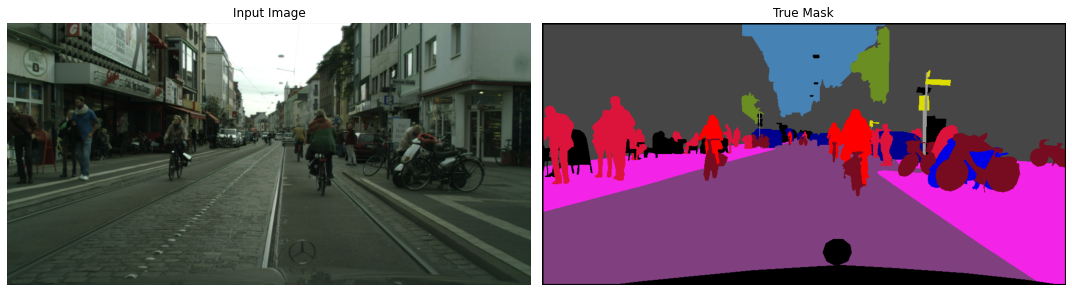

In [19]:
sample_mask = label_to_rgb(sample_mask)
display([sample_image, sample_mask])

In [20]:
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test)

In [21]:
for i, (image, mask) in enumerate(train.take(1)):
    sample_image, sample_mask = image, mask

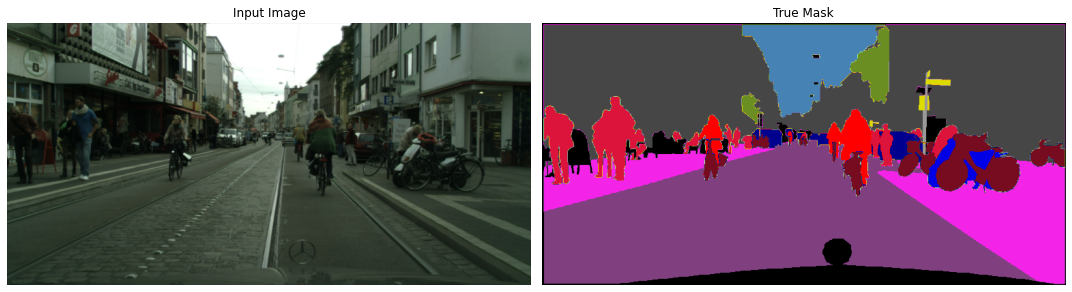

In [22]:
sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])